In [251]:
import torch
import math
import torch.nn as nn
import numpy as np
import pandas as pd
import io
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Any
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

device = "cpu"

In [252]:
from google.colab import files
data_to_load = files.upload()

Saving dataset.csv to dataset (2).csv


Загрузка исходного набора данных

In [253]:
def delete_invalid_rows(frame: pd.DataFrame) -> None:
    """
    Функция удаляет из датафрейма строки с невалидными значениями
    :param frame: Датафрейм из которого происходит удаление
    :return: Функция не возвращает значение
    """
    i = 0
    while i < frame.shape[0]:
        temp = frame.iloc[i]['value']
        if temp is None or temp <= 0 or math.isnan(temp):
            frame.drop(index=i, inplace=True)
            i += 1
        i += 1

def create_dataset(source: str = "dataset.csv") -> pd.DataFrame:
  """
  Функция ситывает данные из файла и превращает их в датафрейм
  :param source: Путь к файлу
  :return: Функция возвращает датафрейм
  """
  dataset = pd.read_csv(source)
  dataset.date = pd.to_datetime(dataset.date, format="%Y-%m-%d")
  delete_invalid_rows(dataset)
  dataset = dataset.set_index(['date'])
  if not dataset.index.is_monotonic:
    dataset = dataset.sort_index()
  return dataset

df = create_dataset()

Разделение загруженного набора данных на обучающую, тестовую и валидационую выборки. Проверка сбалансированности выборок.

In [254]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """
    Функция создает для каждой даты столбцы со значениями с предыдущих дат
    :param df: Датафрейм, в который добавляются столбцы
    :param n_lags: Количество добавляемых столбцов
    :return: Функция возвращает полученный датафрейм
    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags

<ipython-input-254-a7bcf436be08>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n["value"].shift(n)


,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
date,,,,,,,,,,,,,,,,,,,,,
1998-05-30,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,6.1550,6.1465,...,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630,5.9600
1998-06-02,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,6.1550,...,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630
1998-06-03,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,...,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690
1998-06-04,6.1675,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,...,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720
1998-06-05,6.1685,6.1675,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,...,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08,61.2367,62.0955,61.6175,61.4275,61.6229,61.5343,61.3589,61.4277,61.3326,61.1629,...,52.5123,51.1580,52.9699,53.3641,53.3234,53.3578,53.2788,54.7081,56.1727,56.7101
2022-11-09,60.9774,61.2367,62.0955,61.6175,61.4275,61.6229,61.5343,61.3589,61.4277,61.3326,...,53.7676,52.5123,51.1580,52.9699,53.3641,53.3234,53.3578,53.2788,54.7081,56.1727
2022-11-10,61.0611,60.9774,61.2367,62.0955,61.6175,61.4275,61.6229,61.5343,61.3589,61.4277,...,55.0858,53.7676,52.5123,51.1580,52.9699,53.3641,53.3234,53.3578,53.2788,54.7081


In [255]:
def feature_label_split(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """
    Функция разделяет датафрейм на X и Y
    :param df: Датафрейм
    :param target_col: Столбец, который необходимо выделить из датафрейма
    :return: Функция возвращает столбец и оставшуюся часть датафрейма
    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> pd.DataFrame:
    """
    Функция разделяет датафрейм на обучающую, тестовую и валидационную выборки
    :param df: Датафрейм, который функция разделяет
    :param target_col: Столбец, который функция выделяет
    :param test_ratio: Доля тестовой выборки
    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.1)

print(f'X_train: {X_train["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'X_test: {X_test["lag1"].count() / df_timelags["lag1"].count()*100}%')
print(f'X_val: {X_val["lag1"].count() / df_timelags["lag1"].count()*100}%')

X_train: 79.97364953886694%
X_test: 10.013175230566535%
X_val: 10.013175230566535%


In [256]:
def get_scaler(scaler: str) -> sklearn.preprocessing:
    """
    Функция выбирает скейлер датафрейма
    :param scaler: Название скейлера
    :return: Функция возвращает скейлер
    """
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

Создание модели нейронной сети.

In [257]:
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [258]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """
        Конструктор нейронной сети
        :param input_dim: Количество узлов во входном слое
        :param hidden_dim: Количество узлов в каждом слое
        :param layer_dim: Количество слоев в нейронной сети
        :param output_dim: Количество узлов в выходном слое
        :param dropout_prob: Вероятность выпадения узлов
        """
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Функция принимает тензор и выполняет прямое распространение
        :param x: Тензор
        :return: Функция возвращает полученный тензор
        """
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Написание `train loop` и проведение экспериментов с различными значениями `learning rate` и `batch size`.

In [259]:
class Optimization:
    """
    Вспомогательный класс, который позволяет проводить обучение, валидацию, прогнозирование.
    """
    def __init__(self, model: RNNModel, loss_fn: nn.MSELoss, optimizer: optim.Adam) -> None:
        """
        Конструктор класса
        :param model: модель класса нейронной сети
        :param loss_fn: функция потерь для расчета потерь
        :param optimizer: функция оптимизатора для оптимизации функции потерь
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        """
        Функция представляет собой шаг обучения
        :param x: Тензор для обучения
        :param y: Тензор для расчета функции потерь
        """
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train_loop(self, train_loader: DataLoader, val_loader: DataLoader, batch_size: int = 64, n_epochs: int = 50, n_features: int = 1) -> None:
        """
        Функция выполняет обучение модели
        :param train_loader: DataLoader для обучающей выборки
        :param val_loader: DataLoader для валидационной выборки
        :param batch_size: размер мини-пакета
        :param n_epochs: Количество поколений
        :param n_features: Количество столбцов по который производится обучение
        :return: Функция не возвращает значение
        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: DataLoader, batch_size: int = 1, n_features: int = 1) -> list:
        """
        Функция выполняет оценку модели
        :param test_loader: DataLoader для тестовой выборки
        :param batch_size: Размер мини-пакета
        :param n_features: Количество столбцов модели
        :return: Функция возвращает списки результатов
        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        return predictions, values

    def plot_losses(self) -> None:
        """
        Функция показывает на графике полученные значения функции потерь для обучения и валидации
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0460	 Validation loss: 0.0014
[2/100] Training loss: 0.0041	 Validation loss: 0.0010
[3/100] Training loss: 0.0040	 Validation loss: 0.0009
[4/100] Training loss: 0.0038	 Validation loss: 0.0009
[5/100] Training loss: 0.0035	 Validation loss: 0.0008
[6/100] Training loss: 0.0033	 Validation loss: 0.0008
[7/100] Training loss: 0.0030	 Validation loss: 0.0007
[8/100] Training loss: 0.0028	 Validation loss: 0.0007
[9/100] Training loss: 0.0028	 Validation loss: 0.0006
[10/100] Training loss: 0.0026	 Validation loss: 0.0006
[50/100] Training loss: 0.0006	 Validation loss: 0.0001
[100/100] Training loss: 0.0004	 Validation loss: 0.0001


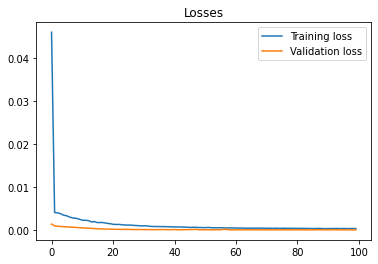

In [260]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train_loop(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [262]:
def inverse_transform(scaler: sklearn.preprocessing, df: pd.DataFrame, columns: tuple) -> pd.DataFrame:
    """
    Функция производит inverse_transform для Датафрейма
    :param scaler: Скейлер для датафрейма
    :param df: Датафрейм
    :param columns: Столбцы, с которыми функция работает
    :return: Функция возвращает полученный датафрейм
    """
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler: sklearn.preprocessing) -> pd.DataFrame:
    """
    Фукнция создает датафрейм с прогнозами
    :param predictions: Список с предсказанными значениями
    :param values: Список с истинными значениями
    :param df_test: Тестовая выборка
    :param scaler: Скейлер для датафрейма
    :return: Функция возвращает датафрейм с прогнозами
    """
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
date,,
1998-07-09,6.209000,6.015035
1998-07-17,6.216000,6.022098
1998-08-20,6.990000,6.223030
1998-08-22,7.005000,6.468639
1998-08-27,7.860000,6.901737
...,...,...
2022-10-11,62.312599,60.417229
2022-10-18,61.763401,62.020725
2022-10-29,61.534302,61.932117


In [263]:
def calculate_metrics(df: pd.DataFrame) -> dict:
    """
    Функция считает метрики качества предсказания
    :param df: Датафрейм со значениями для расчета метрик
    :return: Функция возвращает метрики качества
    """
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)


Mean Absolute Error:        0.5548678
Root Mean Squared Error:    1.4413126266384817
R^2 Score:                  0.9944078331355826


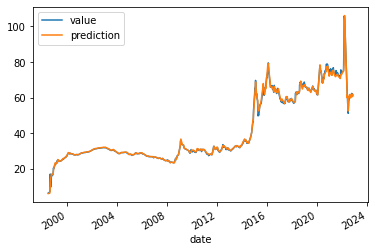

In [264]:
df_result.plot()

In [267]:
def filter_by_date(frame: pd.DataFrame, min_date: pd.Timestamp, max_date: pd.Timestamp) -> pd.DataFrame:
    """
    Функция фильтрует датафрейм по заданным датам
    :param frame: Датафрейм, который функция сортирует
    :param min_date: Минимальная дата для сртировки
    :param max_date: Максимальная дата для ортировки
    :return: Функция не возвращает значение
    """
    return frame[(min_date <= frame.index) & (frame.index <= max_date)]

def comparison(df_result: pd.DataFrame, month: int, year: int) -> None:
    """
    Функция рисует график значений за выбранный месяц
    :param df_result: Датафрейм из значений которого рисуется график
    :param month: Месяц за который рисуется график
    :param year: Выбранный год
    :return: Функция не возвращает значение
    """

    date_1 = pd.Timestamp(year, month, 1)
    date_2 = pd.Timestamp(year, month, date_1.days_in_month)
    df_temp = filter_by_date(df_result, date_1, date_2)
    fig = plt.figure(figsize=(10, 5))
    plt.xlabel("Day")
    plt.ylabel("Value")

    plt.plot(df_temp['value'], color="blue", marker="x", linewidth=2, markersize=4)
    plt.plot(df_temp['prediction'], color="orange", marker="x", linewidth=2, markersize=4)

    plt.legend(["Value", "Prediction value"])
    plt.show()

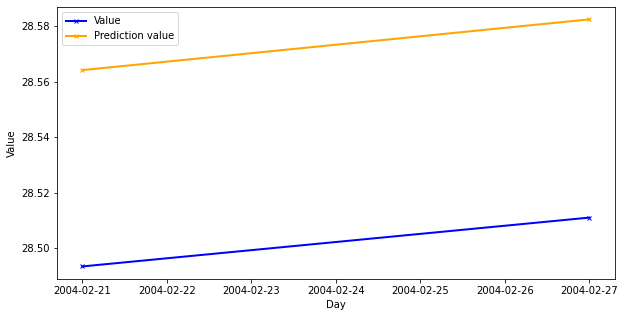

In [270]:
month, year = 2, 2004
comparison(df_result, month, year)